In [1]:
# %%
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.ml.feature import Tokenizer
import nltk
from pyspark.ml.feature import StopWordsRemover
nltk.download('stopwords')
from nltk.corpus import stopwords
from pyspark.ml.feature import IDF
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
# %%
spark = SparkSession.builder \
    .master('local[*]')\
    .appName("NLP")\
    .getOrCreate()

# %%
dados = spark.read.csv("/home/enricolm/Documents/SparkNLP/imdb-reviews-pt-br.csv",
    escape = '\"',
    inferSchema = True,
    header = True                       
)

# %%
dados = dados.withColumn('sentiment', f.when(f.col('sentiment') == "neg", "NEGATIVO").otherwise('POSITIVO'))


# %%
dados = dados.withColumn('texto_regex_pt',f.regexp_replace('text_pt',"[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]",""))
dados = dados.withColumn('texto_regex_en',f.regexp_replace('text_en',"[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]",""))

# %%
dados = dados.withColumn('texto_regex_pt', f.trim(dados['texto_regex_pt']))
dados = dados.withColumn('texto_regex_en', f.trim(dados['texto_regex_en']))


# %%

stop_pt = stopwords.words('portuguese')


# %%

stop_en = StopWordsRemover.loadDefaultStopWords('english')


# tf = HashingTF(inputCol= 'texto_StopWords_pt', outputCol='texto_TF_pt', numFeatures= 100)

# tf = HashingTF(inputCol= 'texto_StopWords_en', outputCol='texto_TF_en', numFeatures= 100)

# idf = IDF(inputCol='texto_TF_pt', outputCol='texto_IDF_pt')

# idf = IDF(inputCol= 'texto_TF_en', outputCol='texto_IDF_en')


si = StringIndexer(inputCol='sentiment' , outputCol= 'label')

dados = si.fit(dados).transform(dados)

dados.na.drop()


tokenizer = Tokenizer(inputCol='texto_regex_pt' , outputCol='texto_tokenizado_pt')
tokenizer_en = Tokenizer(inputCol= 'texto_regex_en', outputCol= 'texto_tokenizer_en')
remover = StopWordsRemover(inputCol='texto_tokenizado_pt', outputCol= 'texto_StopWords_pt', stopWords= stop_pt)
remover_en = StopWordsRemover(inputCol='texto_tokenizer_en', outputCol= 'texto_StopWords_en', stopWords= stop_en)
tf = HashingTF(inputCol= remover.getOutputCol(), outputCol='texto_TF_pt', numFeatures= 1000)
tf_en = HashingTF(inputCol= remover_en.getOutputCol(), outputCol='texto_TF_en', numFeatures= 1000)
idf = IDF(inputCol='texto_TF_pt', outputCol='texto_IDF_pt')
idf_en = IDF(inputCol= 'texto_TF_en', outputCol='texto_IDF_en')


pipeline = Pipeline(stages=[tokenizer,tokenizer_en,remover,remover_en,tf,tf_en,idf,idf_en])

# %%
dados_pipe = pipeline.fit(dados).transform(dados)

# %%
dados_pipe.show(truncate=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/enricolm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
23/06/21 22:06:04 WARN Utils: Your hostname, enricolm-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.233.129 instead (on interface ens33)
23/06/21 22:06:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/21 22:06:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
from pyspark.ml.classification import DecisionTreeClassifier

DTC = DecisionTreeClassifier(featuresCol= 'texto_IDF_pt', labelCol='label')

pipeline = Pipeline(stages=[tokenizer,tokenizer_en,remover,remover_en,tf,tf_en,idf,idf_en,DTC])
dados_pipe = pipeline.fit(dados).transform(dados)

dados_pipe.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en|label| texto_tokenizado_pt|  texto_tokenizer_en|  texto_StopWords_pt|  texto_StopWords_en|         texto_TF_pt|         texto_TF_en|        texto_IDF_pt|        texto_IDF_en|   rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+----------+
|  1|Once again Mr. Co...|Mais 

In [9]:
dados_pipe.select('prediction', 'label').show()

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  0.0|
|       0.0|  0.0|
|       1.0|  0.0|
|       1.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 20 rows



In [10]:
treino, teste = dados.randomSplit([0.7,0.3])

In [13]:
treino_dados = pipeline.fit(treino)

In [15]:
predicao_dados = treino_dados.transform(teste)

In [18]:
predicao_dados.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')


In [26]:
acuracia = evaluator.evaluate(predicao_dados)

In [30]:
print("Valor da acuracia:" , acuracia)

Valor da acuracia: 0.6404195989908379


In [32]:
predicao_dados.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en|label| texto_tokenizado_pt|  texto_tokenizer_en|  texto_StopWords_pt|  texto_StopWords_en|         texto_TF_pt|         texto_TF_en|        texto_IDF_pt|        texto_IDF_en|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  2|This is an exampl...|Este é u

In [48]:
#teste para criar uma nuvem de palavra
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyspark.sql.functions as f
from pyspark.sql.functions import concat_ws

dados_final = predicao_dados.withColumn('Frase_final', f.regexp_replace(concat_ws(" ", predicao_dados['texto_StopWords_pt']), "[\[\],]", "") )

dados_final = dados_final.withColumn('final_phrase', f.regexp_replace(concat_ws(" ", predicao_dados['texto_StopWords_pt']), "[\[\],]", "") )



texto = dados_final.select('Frase_final')
tudo = [text['Frase_final'] for text in texto.collect()]
tudo

['exemplo motivo maioria filmes ação mesmos genérico chato nada valha pena assistir aqui completo desperdício talentos icet cubo gelo mal aproveitados cada comprovando capazes atuar agir bem incomode vá ver new jack city ricochet assistir new york undercover icet boyz hood higher learning friday ice cube ver negócio real icets horrivelmente clichê diálogo sozinho faz filme ralar dentes ainda perguntando diabos bill paxton fazendo neste filme diabos sempre interpreta exatamente personagem extraterrestres diante todos filmes vi bill paxton fizeram interpretar exatamente personagem irritante menos aliens personagem morreu tornou pouco gratificante  geral lixo ação segunda classe existem incontáveis \u200b\u200bfilmes melhores ver realmente quiser ver filme assista judgment night praticamente cópia carbono melhor atuação roteiro melhor única coisa fez valer pena assistir mão decente câmera  cinematografia quase refrescante chega perto compensar horrível filme si  bem assim 410',
 'primeiro

In [49]:
nuvem = WordCloud(background_color='white',
                  width=1000,
                  height=600,
                  collocations=False,
                  prefer_horizontal=1).generate(str(tudo))


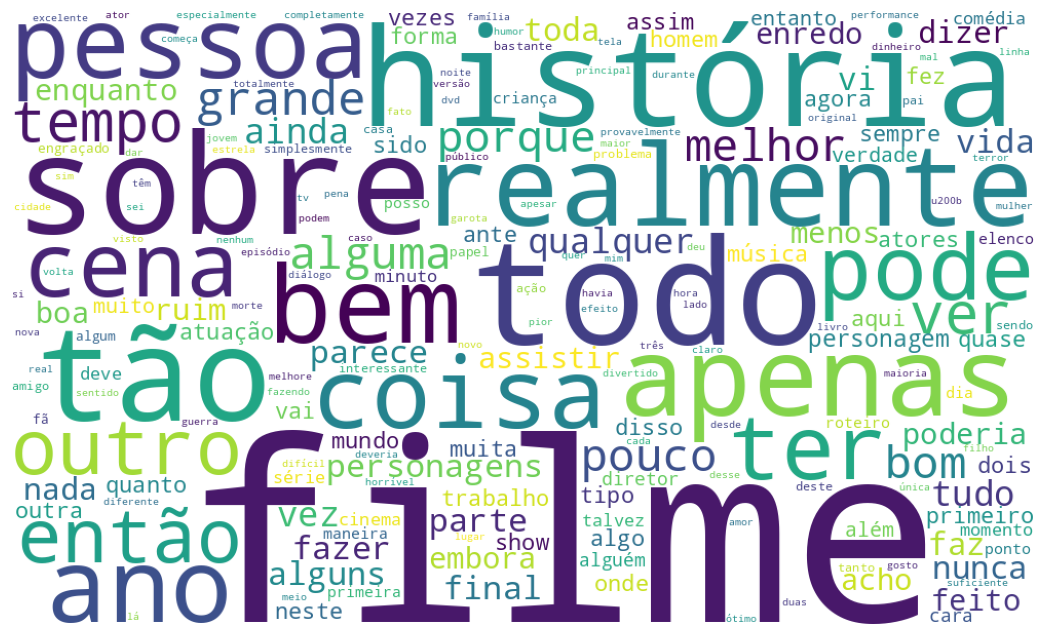

In [50]:
plt.figure(figsize=(20,8))
plt.imshow(nuvem)
plt.axis("off")
plt.show()